In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
WIDTH = 1280
HEIGHT = 720

def create_avg_image_1(path):
  capture = cv2.VideoCapture(path)
  avg_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    avg_image += gray
  return avg_image / np.max(avg_image) * 255

def create_avg_image_3(path, start_frame, end_frame):
  capture = cv2.VideoCapture(path, cv2.IMREAD_GRAYSCALE)
  capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
  avg_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(end_frame - start_frame):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    avg_image += gray
  return avg_image / np.max(avg_image) * 255

def create_avg_colored_image_1(path):
  capture = cv2.VideoCapture(path)
  avg_image = np.zeros((HEIGHT, WIDTH, 3), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    avg_image += frame
  return avg_image / np.max(avg_image) * 255

def create_star_trail(path):
  capture = cv2.VideoCapture(path)
  trail = np.zeros((HEIGHT, WIDTH, 3), dtype='uint8')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    np.maximum(frame, trail, out=trail)
  return trail

def get_highlighted_image_2(path, avg):
  capture = cv2.VideoCapture(path)
  highlighted_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    current = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = current - avg
    diff[diff < 60] = 0
    highlighted_image += np.maximum(diff.astype('float'), 0)
  return highlighted_image / np.max(highlighted_image) * 255

def get_highlighted_image_4(path, avg, start_frame, end_frame):
  capture = cv2.VideoCapture(path)
  capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
  highlighted_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(end_frame - start_frame):
    _, frame = capture.read()
    current = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = current - avg
    diff[diff < 60] = 0
    highlighted_image += np.maximum(diff.astype('float'), 0)
  return highlighted_image / np.max(highlighted_image) * 255

def remove_background(gray_frame):
  med = cv2.medianBlur(gray_frame, 5)
  return gray_frame.astype('float') - med.astype('float')

def remove_labels(colored, target):
  green = colored[:, :, 1].astype('float')
  blue = colored[:, :, 2].astype('float')
  grey = np.average(colored, axis=2)

  G = green - grey
  G[G >= 10] = 255
  G[G<10] = 0

  B = blue - grey
  B[B >= 10] = 255
  B[B<10] = 0

  target[G == 255] = 0
  target[B == 255] = 0
  return target

def get_number_of_frames(path):
  return int(cv2.VideoCapture(path).get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
def get_frame(path, index):
  capture = cv2.VideoCapture(path)
  frame = np.zeros((HEIGHT, WIDTH), dtype='uint8')
  for i in range(index + 1):
    _, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  return frame

In [ ]:
def compute_theta(values, pct):
  min_ = min(values)
  max_ = max(values)
  R = (max_ - min_) / 10
  for i in range(10):
    count = 0.0
    for value in values:
      if value < R * (i + 1):
        count += 1
    if count / len(values) >= pct:
      return R * (i + 1)
  return None

def get_values_with_noise(path, window_size, noise):
  values = []
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    H = np.maximum((H - noise).astype('float'), 0)
    values.append(np.sum(H))
    frame_index += window_size
  return values


def get_values(path, window_size):
  values = []
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    values.append(np.sum(H))
    frame_index += window_size
  return values

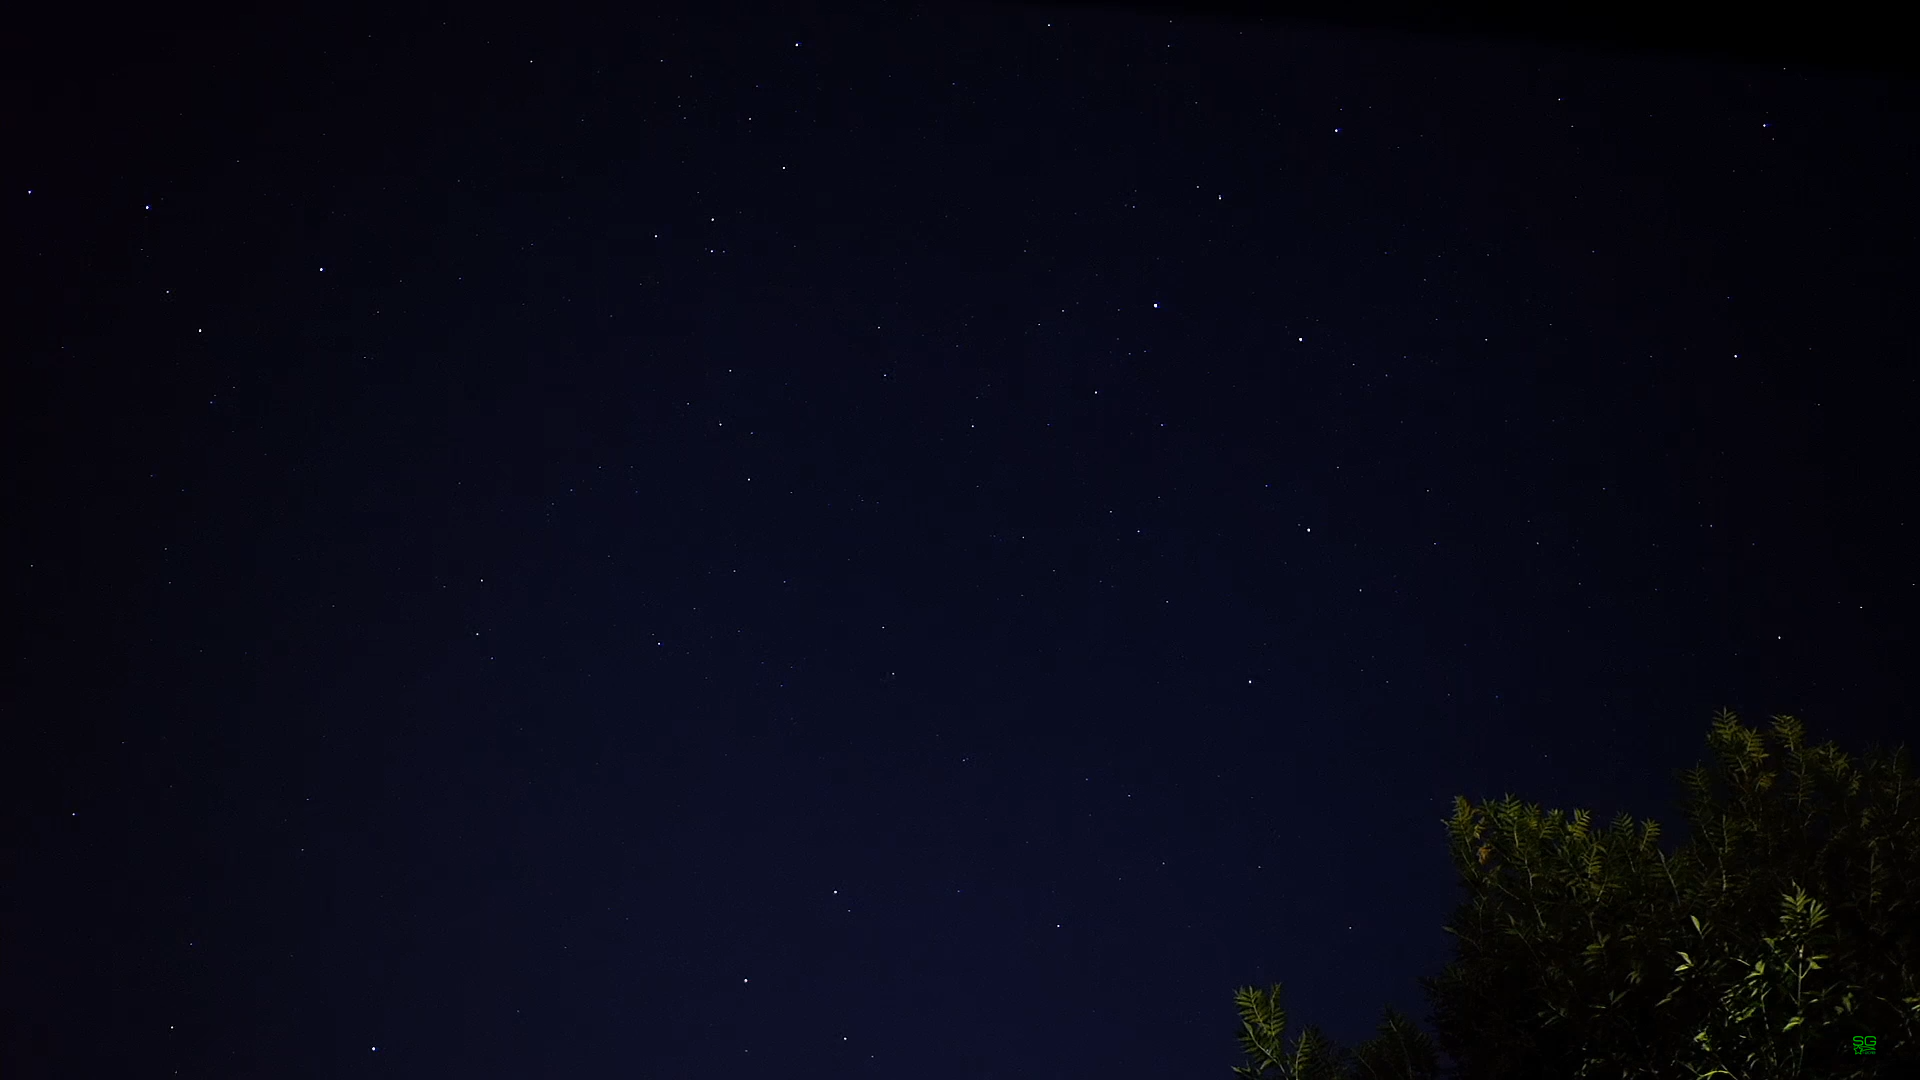

In [ ]:
img0 = cv2.imread('img0.png')
cv2_imshow(img0)

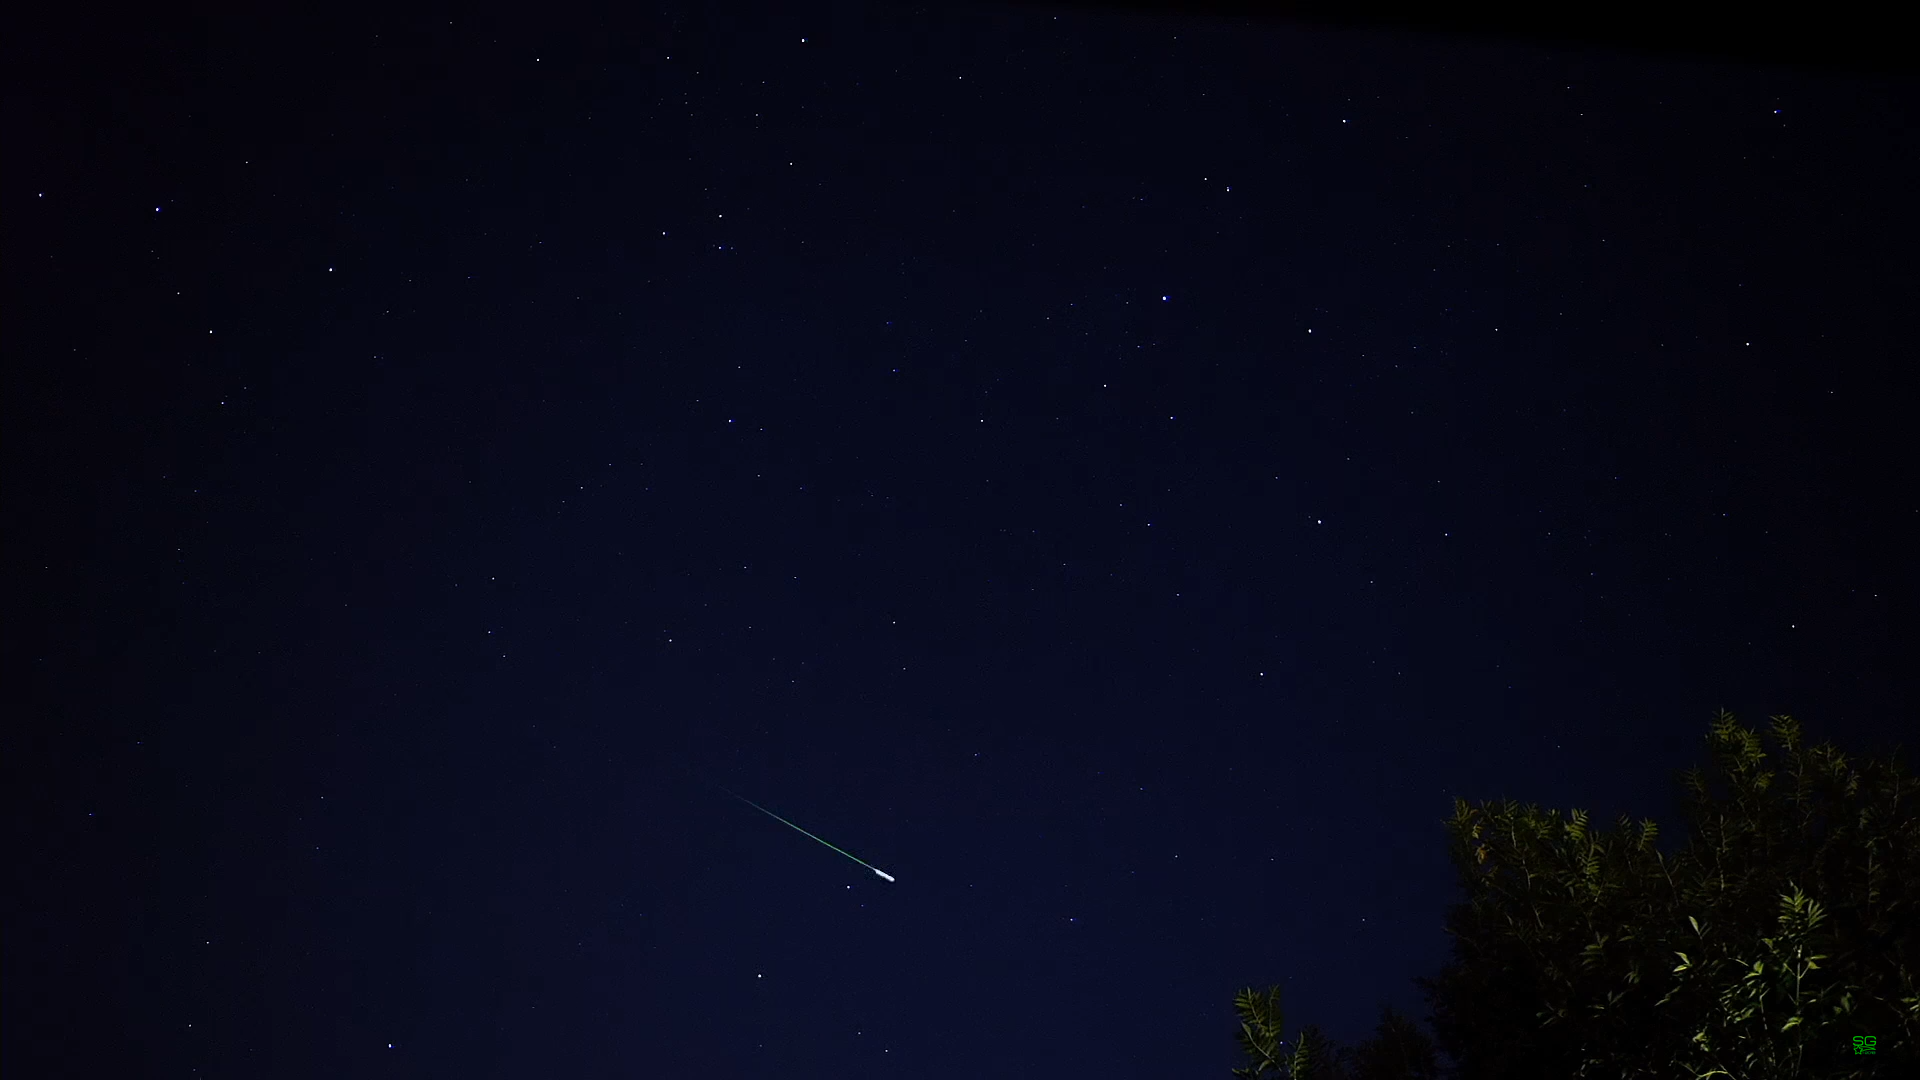

In [ ]:
cv2_imshow(cv2.imread('img1.png'))

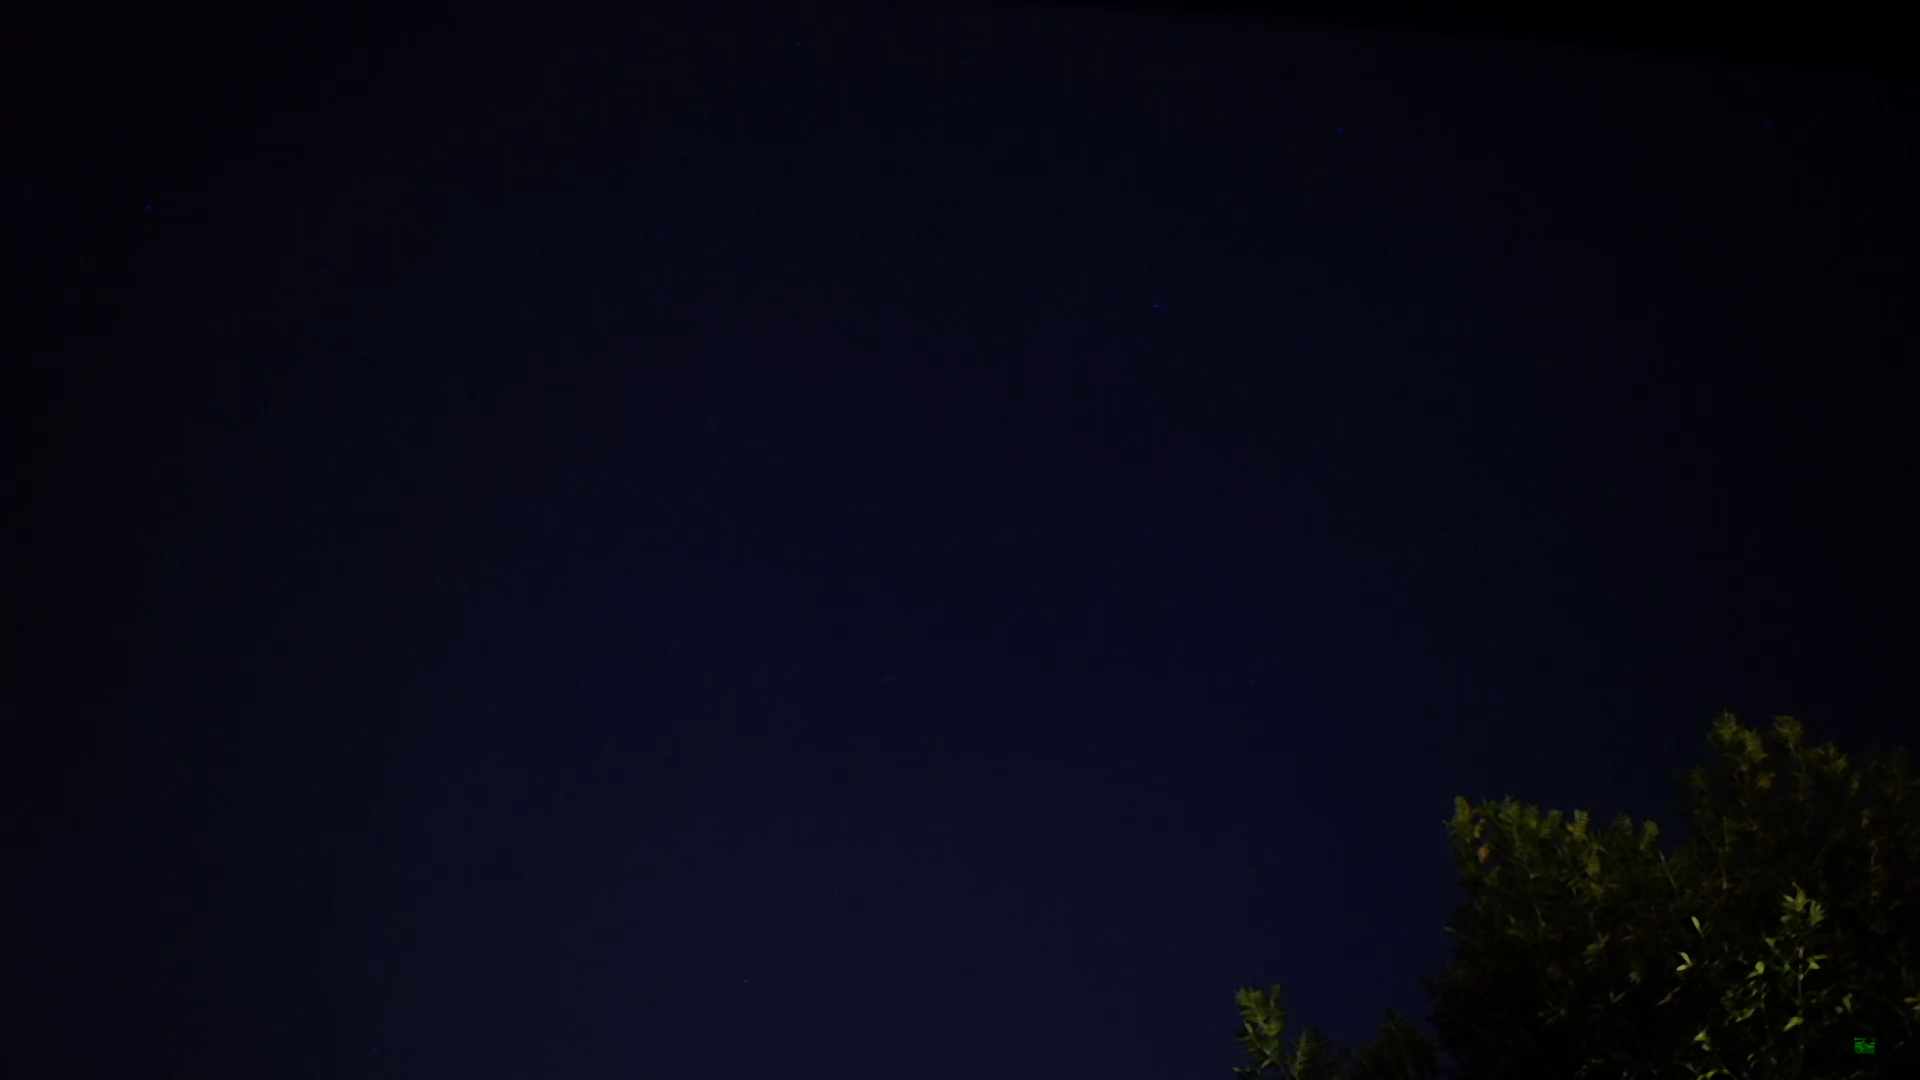

In [ ]:
cv2_imshow(cv2.medianBlur(img0, 5))

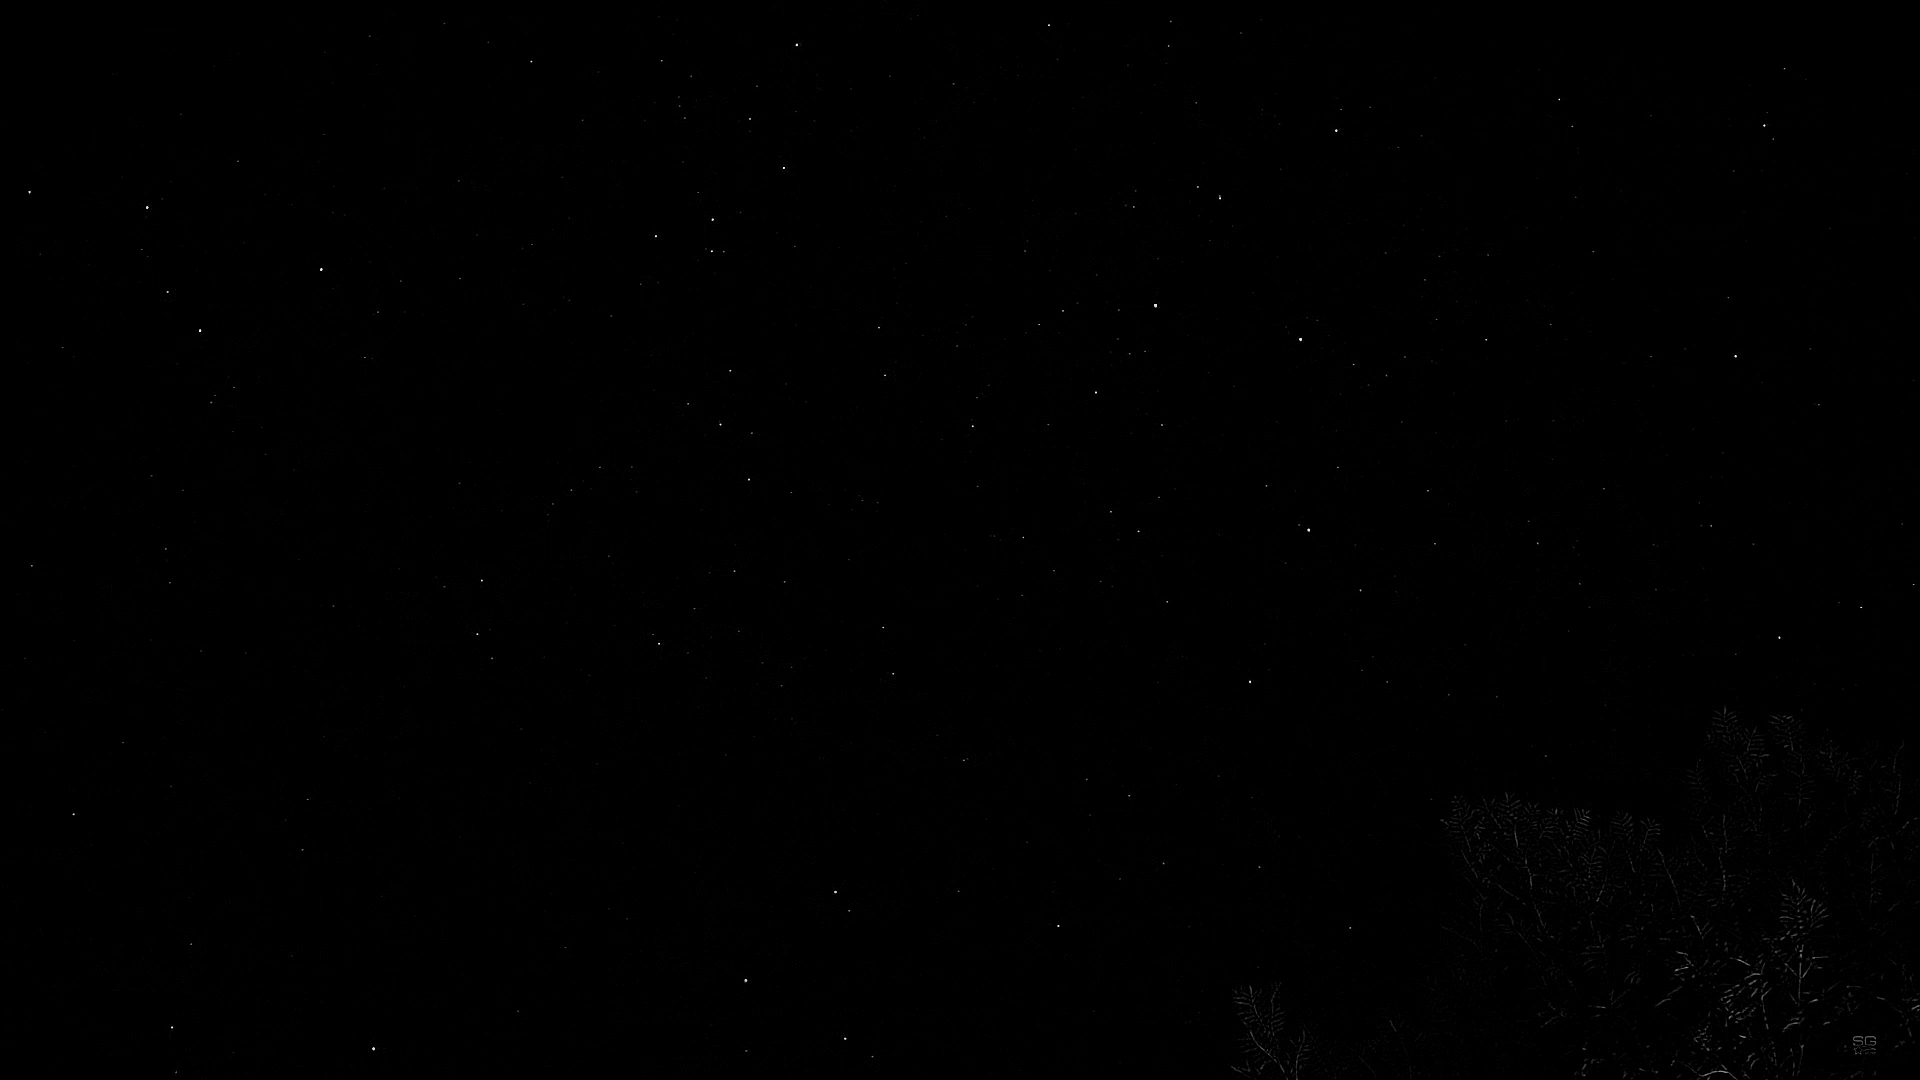

In [ ]:
cv2_imshow(remove_background(cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)))

#Zaj maszk: összes kép élkiemelése és normalizálása [0-255] közé:
# <center> ${M}_{noise} = \left\lvert \sum \limits _{i=0} ^{N} \left\lvert G(i) \right\rvert \right\rvert $

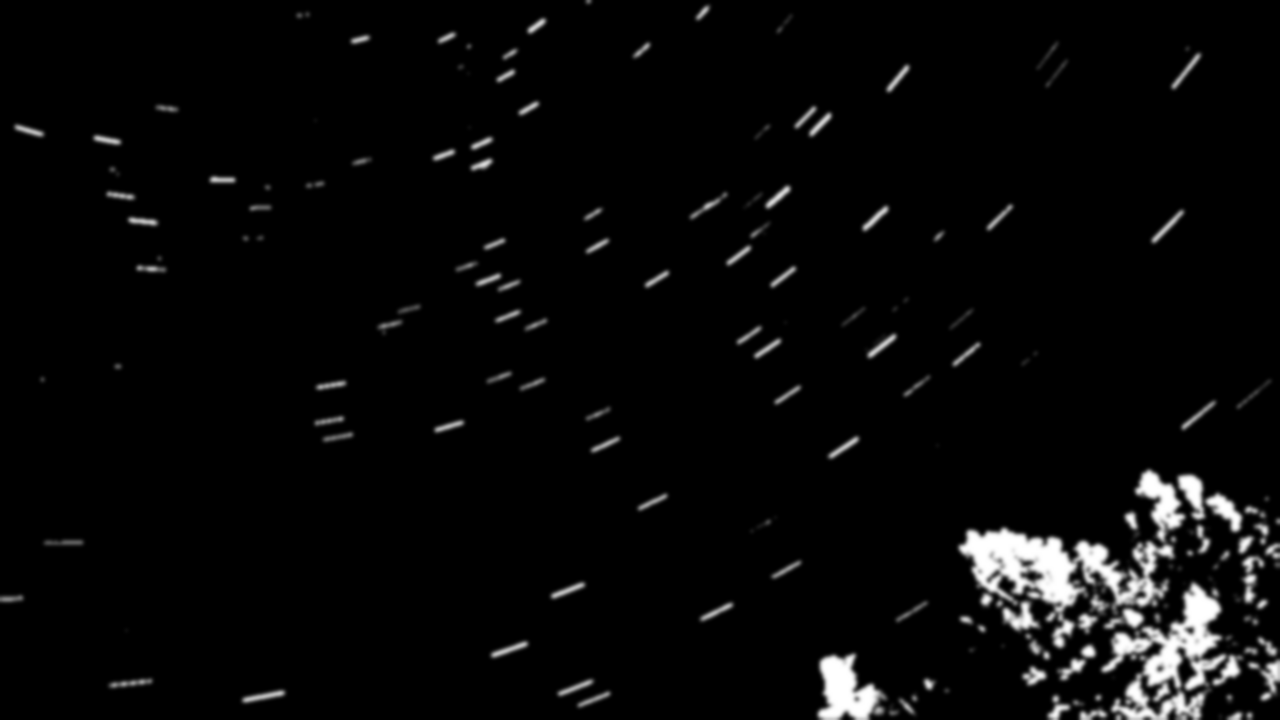

In [ ]:
def get_noise_mask(path):
  capture = cv2.VideoCapture(path)
  acc = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, 5)
    acc += np.abs(sobel.astype('float'))

  acc = acc / np.max(acc) * 255
  acc[acc < 10] = 0
  acc[acc >= 10] = 255
  return cv2.GaussianBlur(acc, (11, 11), 0)

mask = get_noise_mask('videos/full10.mp4')
cv2_imshow(mask)

# Átlag kép adott időtartományban [0-255] közé normalizálva:
# <center> ${Avg}_{t, w} = \left\lvert \sum \limits _{t} ^{t+w}  I(t) \right\rvert $

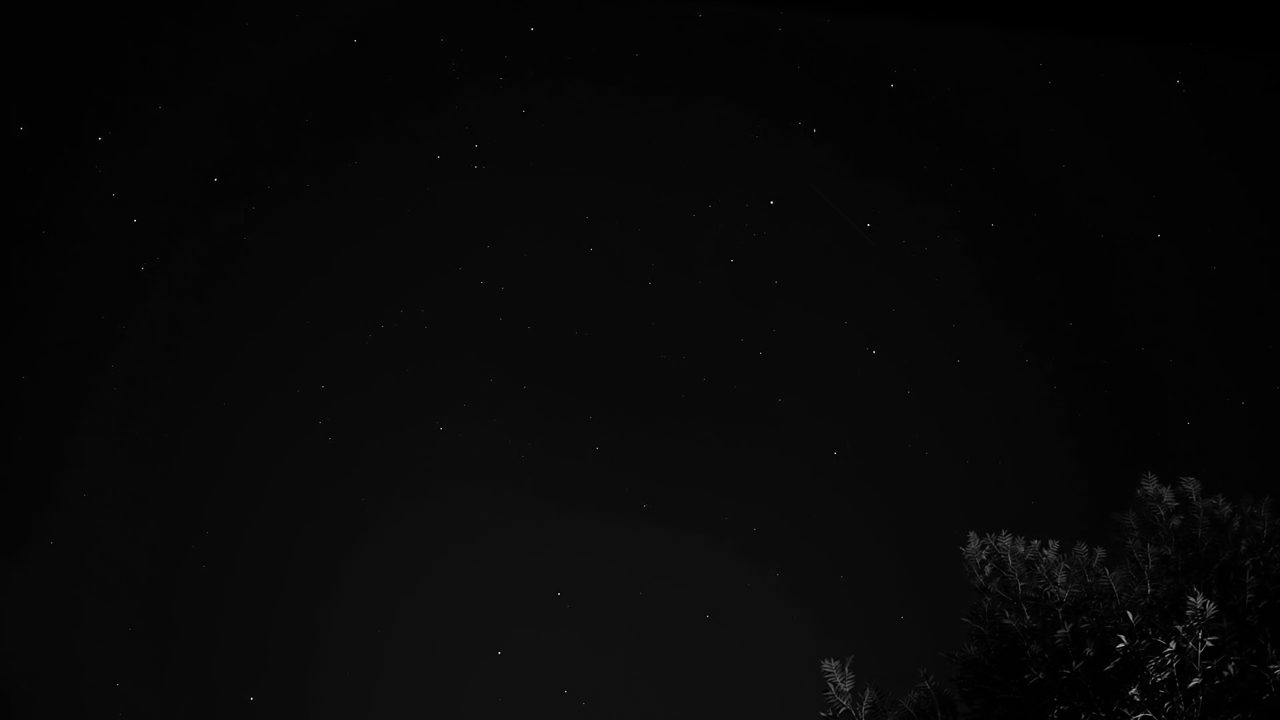

In [ ]:
def create_avg_image_3(path, start_frame, end_frame):
  capture = cv2.VideoCapture(path, cv2.IMREAD_GRAYSCALE)
  capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
  avg_image = np.zeros((HEIGHT, WIDTH), dtype='float')
  for i in range(end_frame - start_frame):
    _, frame = capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    avg_image += gray
  return avg_image / np.max(avg_image) * 255

avg = create_avg_image_3('videos/full10.mp4', 3500, 3700)
cv2_imshow(avg)

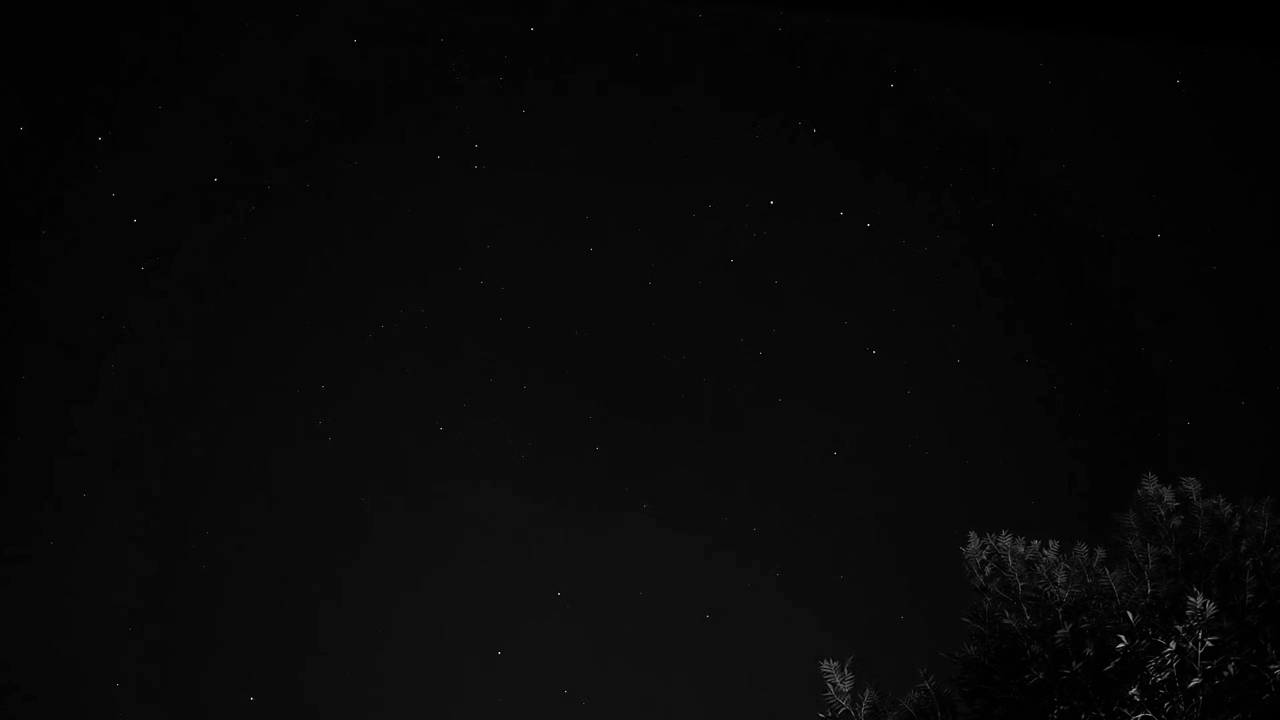

In [ ]:
current = get_frame('videos/full10.mp4', 3600)
cv2_imshow(current)

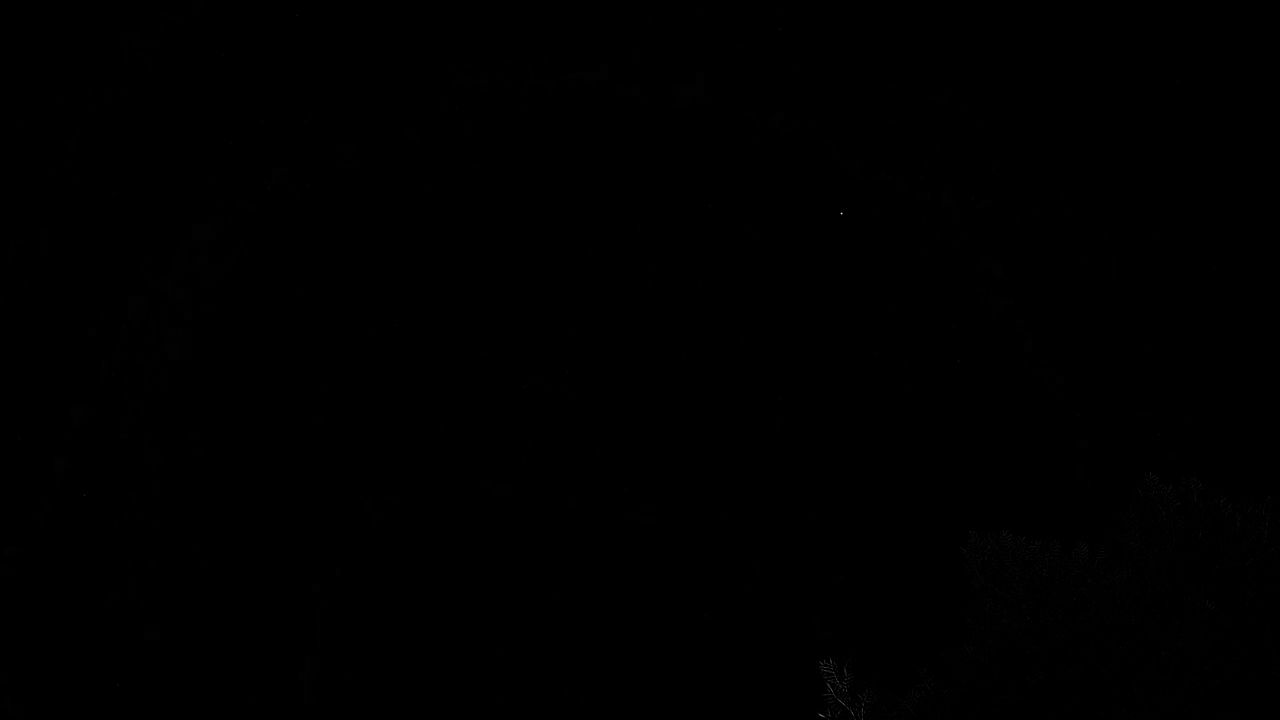

In [ ]:
# A kettőt kivonva megkapjuk az oda nem illő objektumokat:
cv2_imshow(np.maximum(current - avg, 0))

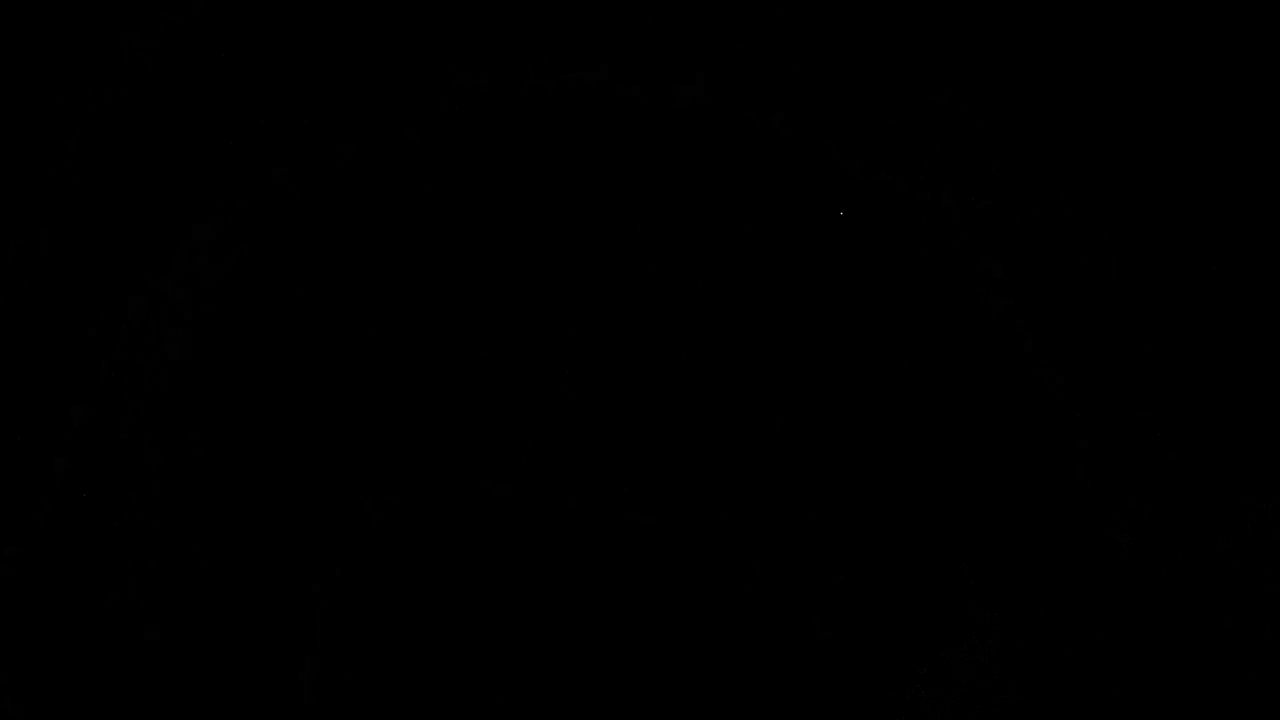

In [ ]:
cv2_imshow(np.maximum(current - avg - mask, 0))

# <center> ${H}_{t, w} = \left\lceil (\sum \limits _{t} ^{t+w}  I(t) - Avg_{t, w}) - M_{noise} \right\rceil $

# "Érdekes" egy időtartomány, ha ${H}_{t, w}$ összege meghalad egy küszöbértéket.

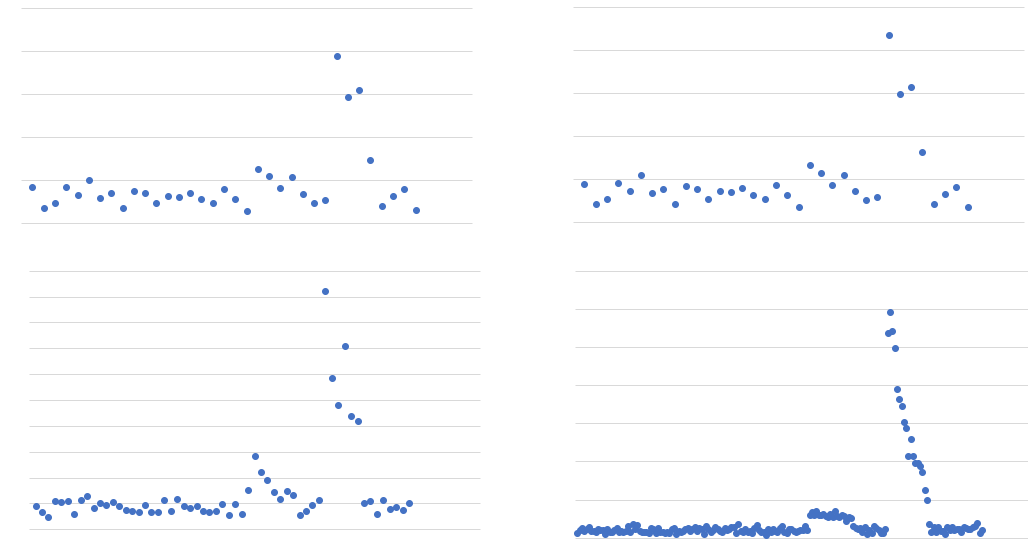

In [ ]:
cv2_imshow(cv2.imread('sampling.png'))

In [ ]:
def process_video(path, window_size, theta):
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    if np.sum(H) > theta:
      H[H > 10] = 255
      #cv2_imshow(H)
      #print(frame_index)
      #cv2.imwrite(str(frame_index) + '.jpg', H)
    frame_index += window_size

def process_video_stacked(path, window_size, theta):
  frame_index = 0
  length = get_number_of_frames(path)
  acc = np.zeros((HEIGHT, WIDTH), dtype='float')
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    if np.sum(H) > theta:
      H[H > 10] = 255
      acc += H
      #cv2_imshow(H)
      #cv2.imwrite(str(frame_index) + '.jpg', H)
    frame_index += window_size
  return np.minimum(acc, 255)

def process_noisy_video(path, window_size, theta, noise):
  frame_index = 0
  length = get_number_of_frames(path)
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    H = np.maximum((H - noise).astype('float'), 0)
    if np.sum(H) > theta:
      H[H > 10] = 255
      #cv2_imshow(H)
      #cv2.imwrite(str(frame_index) + '.jpg', H)
    frame_index += window_size

def process_noisy_video_stacked(path, window_size, theta, noise):
  frame_index = 0
  length = get_number_of_frames(path)
  acc = np.zeros((HEIGHT, WIDTH), dtype='float')
  while frame_index + window_size < length:
    avg = create_avg_image_3(path, frame_index, frame_index + window_size)
    H = get_highlighted_image_4(path, avg, frame_index, frame_index + window_size)
    H = np.maximum((H - noise).astype('float'), 0)
    if np.sum(H) > theta:
      H[H > 10] = 255
      #cv2_imshow(H)
      #cv2.imwrite(str(frame_index) + '.jpg', H)
      acc += H
    frame_index += window_size

  return np.minimum(acc, 255)

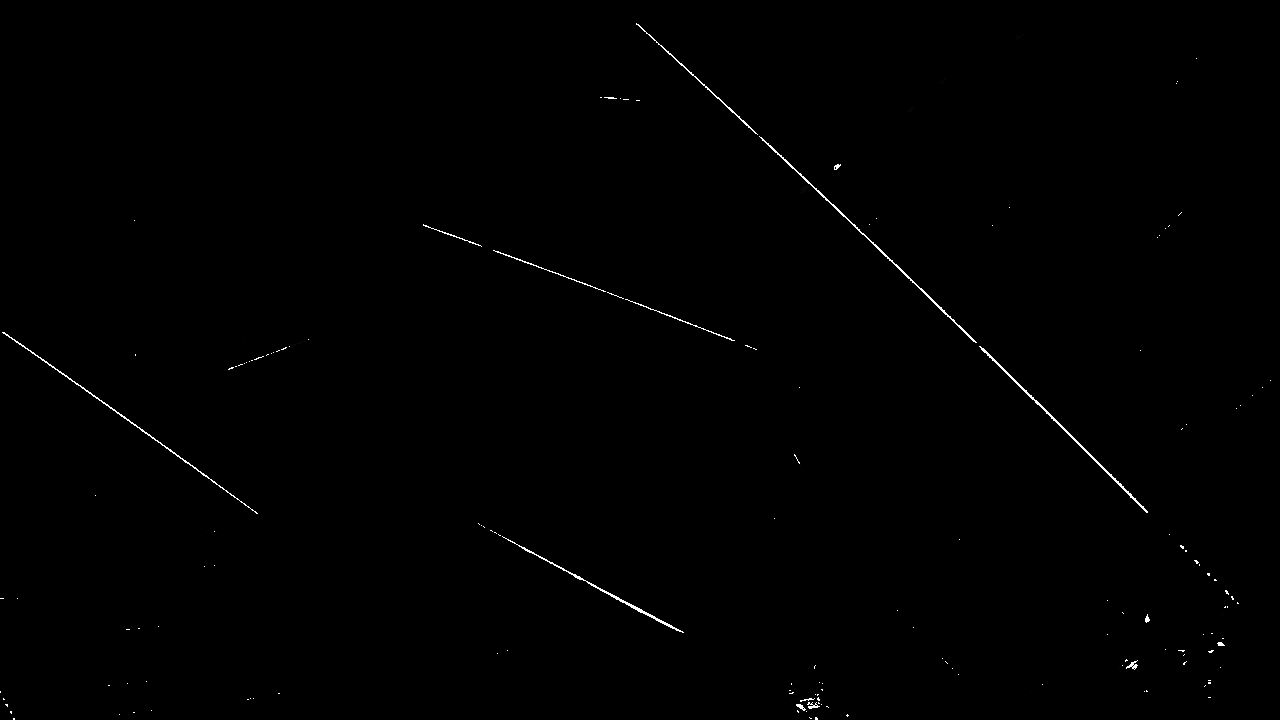

In [ ]:
result = process_noisy_video_stacked('videos/full10.mp4', 300, 1689, mask)
cv2_imshow(result)

In [ ]:
compute_theta(get_values_with_noise('videos/full10.mp4', 300, mask), 0.5)

1689.1188408375579

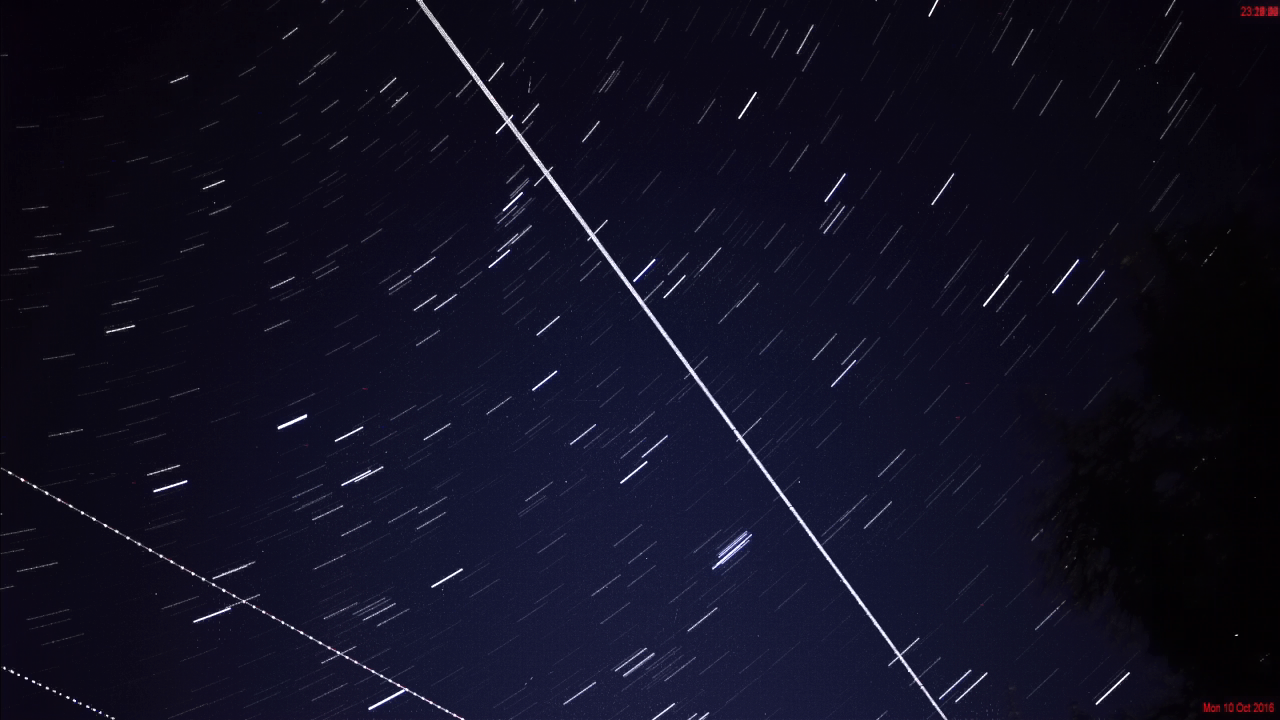

In [ ]:
trail = create_star_trail('videos/sample.mp4')
cv2_imshow(trail)

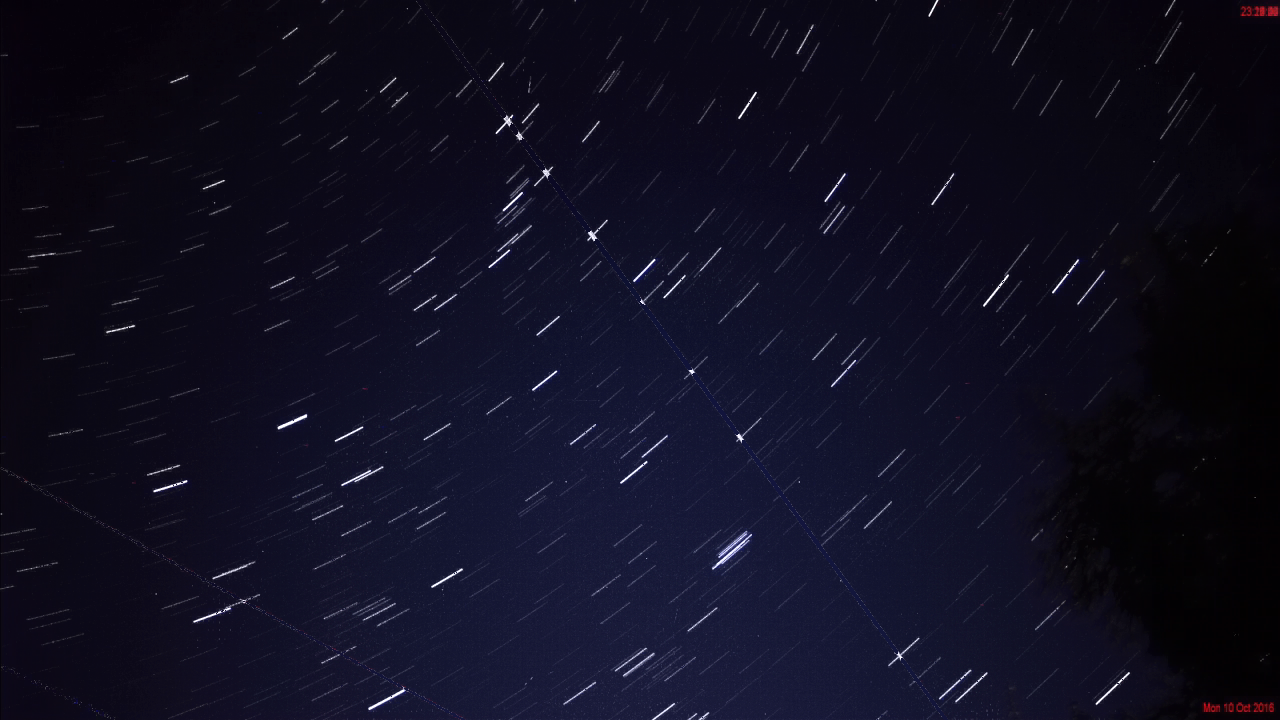